In [ ]:
from mfglib.env import Environment
from mfglib.alg.utils import _ensure_free_tensor
from mfglib.mean_field import mean_field
import torch
from mfglib.alg.greedy_policy_given_mean_field import Greedy_Policy
import matplotlib.pyplot as plt
from mfglib.alg import MFOMO,PriorDescent, FictitiousPlay
from mfglib.metrics import exploitability_score
from mpl_toolkits.mplot3d import Axes3D

c:\Users\minghuiw\AppData\Local\anaconda3\envs\mfg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cal_diff(mu0, mu1):
    return torch.sum((mu0-mu1)**2)

torch.Size([10, 3])
            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(10,)
	A(3,)
	T=3
	r_max=10

Algorithm summary:
	FictitiousPlay(alpha=None)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 1.74481  |     1.00000     |          0           |  0.000   |
|  1   | 0.32593  |     0.18680     |          1           |  0.017   |
|  2   | 0.23557  |     0.13501     |          2           |  0.023   |
|  3   | 0.21781  |     0.12483     |          3           |  0.023   |
|  4   | 0.12521  |     0.07176     |          4           |  0.033   |
|  5   | 0.09420  |     0.05399     |          5           |  0.035   |
|  6   | 0.08280  |     0.04746     |          

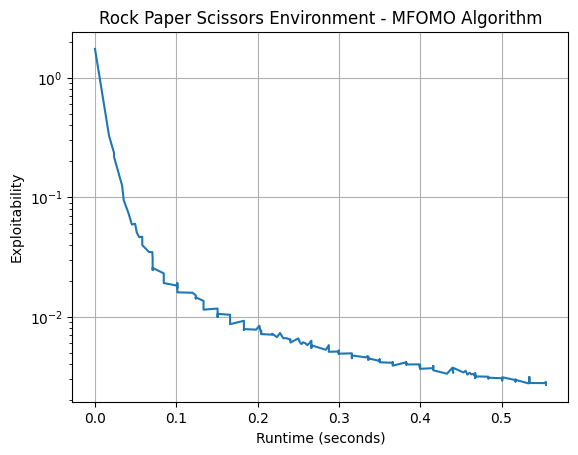

In [3]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
solns, expls, runtimes = FictitiousPlay().solve(env_instance, max_iter=5000, verbose=True)
plt.semilogy(runtimes, exploitability_score(env_instance, solns)) 
plt.grid(True)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Exploitability")
plt.title("Rock Paper Scissors Environment - MFOMO Algorithm")
plt.show()

In [ ]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
diff_record = []
weight = 1/5
exp_record = []

for i in range(100):
    print(f'iter = {i}')
    solns, expls, runtimes = FictitiousPlay().solve(env_instance, max_iter=3, verbose=False)
    pi = solns[-1]
    # now pi, and mean_field(env, pi) is a MFE for env.mu0
    print(f'for temp MFE: exp = {exploitability_score(env_instance, pi)}')
    L = mean_field(env_instance, pi)
    mu = torch.sum(L, axis=2)
    diff = cal_diff(mu[0], mu[-1])
    diff_record.append(diff)
    print(f'for temp MFE, diff = {diff}')

    for j in range(1):
        mu0 = mu[0]
        muN = mu[-1]
        mu0 = 1/2 * mu0 + 1/2 * muN
        mu0 /= torch.sum(mu0)
        env_instance.update_initial_distribution(mu0)
        L = mean_field(env_instance, pi)
        mu = torch.sum(L, axis=2)
    # now pi should induce mu from mu_N
    diff = cal_diff(mu[0], mu[-1])
    print(f'for self-consistent pair, diff = {diff}')
    exp = exploitability_score(env_instance, pi)
    print(f'for self-consistent pair, exp = {exp}')
    exp_record.append(exp)

    

torch.Size([10, 3])
iter = 0
for temp MFE: exp = 0.21780681610107422
for temp MFE, diff = 0.03505595400929451
for self-consistent pair, diff = 0.018963385373353958
for self-consistent pair, exp = 0.27590084075927734
iter = 1
for temp MFE: exp = 0.2159595489501953
for temp MFE, diff = 0.009801877662539482
for self-consistent pair, diff = 0.005381693597882986
for self-consistent pair, exp = 0.27301597595214844
iter = 2
for temp MFE: exp = 0.19765853881835938
for temp MFE, diff = 0.0041747670620679855
for self-consistent pair, diff = 0.0023023858666419983
for self-consistent pair, exp = 0.22006797790527344
iter = 3
for temp MFE: exp = 0.15885257720947266
for temp MFE, diff = 0.0011670887470245361
for self-consistent pair, diff = 0.0006036360864527524
for self-consistent pair, exp = 0.1748042106628418
iter = 4
for temp MFE: exp = 0.1897573471069336
for temp MFE, diff = 0.0003224398533347994
for self-consistent pair, diff = 0.00015990951214917004
for self-consistent pair, exp = 0.1871829032

In [30]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
diff_record = []
exp_record = []
pibar = None
for i in range(100):
    print(f'iter = {i}')
    solns, expls, runtimes = FictitiousPlay().solve(env_instance, max_iter=5000, verbose=False)
    pi_mfe = solns[-1]
    if pibar is not None:
        weight_pi = 1 / i ** 1
        pibar = (1-weight_pi) * pibar + weight_pi * pi_mfe
    else:
        pibar = pi_mfe
    
    # now pi, and mean_field(env, pi) is a MFE for env.mu0
    print(f'for temp MFE: exp = {exploitability_score(env_instance, pibar)}')
    L = mean_field(env_instance, pibar)
    mu = torch.sum(L, axis=2)
    diff = cal_diff(mu[0], mu[-1])
    diff_record.append(diff)
    print(f'for temp MFE, diff = {diff}')

    instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
    mu[0]/= torch.sum(mu[0])
    instance.update_initial_distribution(mu[0])
    mu_test = mu.clone()
    for j in range(20):
        mu0 = mu_test[0]
        muN = mu_test[-1]
        mu0 = 1/2 * mu0 + 1/2 * muN
        mu0 /= torch.sum(mu0)
        instance.update_initial_distribution(mu0)
        L = mean_field(instance, pibar)
        mu_test = torch.sum(L, axis=2)
    new_mu0 = mu_test[0]
    if i == 0:
        new_mu0 = new_mu0
    else:
        weight_initial = 1 / i ** 0.6
        new_mu0 = (1-weight_initial) * mu[0] + weight_initial*new_mu0
    new_mu0 /= torch.sum(new_mu0)
    env_instance.update_initial_distribution(new_mu0)
    
    # now pi should induce mu from mu_N
    diff = cal_diff(mu_test[0], mu_test[-1])
    print(f'for self-consistent pair, diff = {diff}')
    exp = exploitability_score(env_instance, pibar)
    print(f'for self-consistent pair, exp = {exp}')
    exp_record.append(exp)


torch.Size([10, 3])
iter = 0
for temp MFE: exp = 0.002677440643310547
for temp MFE, diff = 0.03094855695962906
torch.Size([10, 3])
for self-consistent pair, diff = 2.469020046191872e-07
for self-consistent pair, exp = 5.727783679962158
iter = 1
for temp MFE: exp = 0.00173187255859375
for temp MFE, diff = 0.026092635467648506
torch.Size([10, 3])
for self-consistent pair, diff = 0.00020082718401681632
for self-consistent pair, exp = 6.817035675048828
iter = 2
for temp MFE: exp = 2.336113929748535
for temp MFE, diff = 0.030550405383110046
torch.Size([10, 3])
for self-consistent pair, diff = 6.273016333580017e-05
for self-consistent pair, exp = 0.6730856895446777
iter = 3
for temp MFE: exp = 0.3775978088378906
for temp MFE, diff = 0.007372616324573755
torch.Size([10, 3])
for self-consistent pair, diff = 3.7218087527435273e-06
for self-consistent pair, exp = 0.44098949432373047
iter = 4
for temp MFE: exp = 0.2653799057006836
for temp MFE, diff = 0.0020454309415072203
torch.Size([10, 3])
for

[5.727783679962158, 6.817035675048828, 0.6730856895446777, 0.44098949432373047, 0.4123668670654297, 0.3249688148498535, 0.21459054946899414, 0.12253284454345703, 0.06887340545654297, 0.04522418975830078, 0.03524923324584961, 0.0333552360534668, 0.03597116470336914, 0.03830099105834961, 0.039617061614990234, 0.04138326644897461, 0.041738033294677734, 0.041896820068359375, 0.041132450103759766, 0.0396575927734375, 0.037717342376708984, 0.03552055358886719, 0.03326559066772461, 0.031068801879882812, 0.028976917266845703, 0.027031421661376953, 0.025152206420898438, 0.0234375, 0.0221099853515625, 0.020893096923828125, 0.019758224487304688, 0.018692970275878906, 0.017696857452392578, 0.016774654388427734, 0.015913963317871094, 0.015112876892089844, 0.014417171478271484, 0.01385354995727539, 0.013335227966308594, 0.012857437133789062, 0.012423038482666016, 0.012020587921142578, 0.011648178100585938, 0.011309146881103516, 0.010995864868164062, 0.010708332061767578, 0.010441303253173828, 0.0101

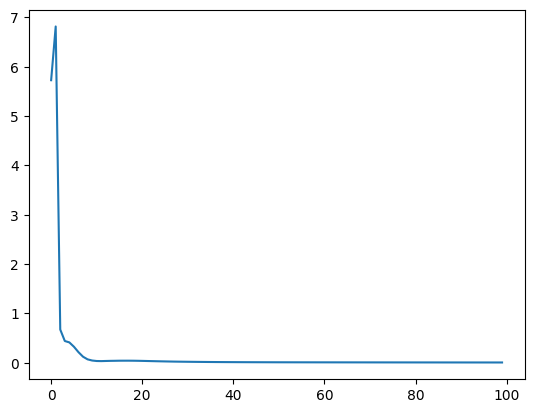

In [31]:
print(exp_record)
plt.plot(exp_record)
L = mean_field(env_instance, pibar)
mu = torch.sum(L, axis=2)
print(mu)

In [19]:
env_instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
diff_record = []
weight = 1/10
exp_record = []

for i in range(30):
    print(f'iter = {i}')
    solns, expls, runtimes = FictitiousPlay().solve(env_instance, max_iter=5000, verbose=False)
    pi = solns[-1]
    # now pi, and mean_field(env, pi) is a MFE for env.mu0
    print(f'for temp MFE: exp = {exploitability_score(env_instance, pi)}')
    L = mean_field(env_instance, pi)
    mu = torch.sum(L, axis=2)
    diff = cal_diff(mu[0], mu[-1])
    diff_record.append(diff)
    print(f'for temp MFE, diff = {diff}')
    instance = Environment.beach_bar(n=10, bar_loc=5, T=3)
    mu[0]/= torch.sum(mu[0])
    instance.update_initial_distribution(mu[0])
    mu_test = mu.clone()
    for j in range(20):
        mu0 = mu_test[0]
        muN = mu_test[-1]
        mu0 = 1/2 * mu0 + 1/2 * muN
        mu0 /= torch.sum(mu0)
        instance.update_initial_distribution(mu0)
        L = mean_field(instance, pi)
        mu_test = torch.sum(L, axis=2)
    new_mu0 = mu_test[0]
    new_mu0 /= torch.sum(new_mu0)
    env_instance.update_initial_distribution(new_mu0)
    
    # now pi should induce mu from mu_N
    diff = cal_diff(mu[0], mu[-1])
    print(f'for self-consistent pair, diff = {diff}')
    exp = exploitability_score(env_instance, pi)
    print(f'for self-consistent pair, exp = {exp}')
    exp_record.append(exp)


torch.Size([10, 3])
iter = 0
for temp MFE: exp = 0.002677440643310547
for temp MFE, diff = 0.03094855695962906
torch.Size([10, 3])
for self-consistent pair, diff = 0.03094855695962906
for self-consistent pair, exp = 5.727783679962158
iter = 1
for temp MFE: exp = 0.00173187255859375
for temp MFE, diff = 0.026092635467648506
torch.Size([10, 3])
for self-consistent pair, diff = 0.026092661544680595
for self-consistent pair, exp = 6.817035675048828
iter = 2
for temp MFE: exp = 0.004038095474243164
for temp MFE, diff = 0.18072572350502014
torch.Size([10, 3])
for self-consistent pair, diff = 0.18072572350502014
for self-consistent pair, exp = 12.631949424743652
iter = 3
for temp MFE: exp = 0.0018210411071777344
for temp MFE, diff = 0.07297980040311813
torch.Size([10, 3])
for self-consistent pair, diff = 0.0729798972606659
for self-consistent pair, exp = 11.764567375183105
iter = 4
for temp MFE: exp = 0.00459742546081543
for temp MFE, diff = 0.2833429276943207
torch.Size([10, 3])
for self-con

KeyboardInterrupt: 

In [6]:
print(pi)
L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
print(mu)

tensor([[[8.6356e-04, 8.6356e-04, 9.9827e-01],
         [8.6356e-04, 9.9827e-01, 8.6356e-04],
         [9.9827e-01, 8.6356e-04, 8.6356e-04]],

        [[1.2325e-03, 5.8090e-01, 4.1787e-01],
         [4.9377e-04, 9.9901e-01, 4.9377e-04],
         [4.1787e-01, 5.8090e-01, 1.2325e-03]],

        [[1.0942e-03, 9.9781e-01, 1.0942e-03],
         [5.5389e-04, 9.9889e-01, 5.5389e-04],
         [1.0942e-03, 9.9781e-01, 1.0942e-03]]])
tensor([[0.2866, 0.4269, 0.2866],
        [0.2503, 0.4994, 0.2503],
        [0.2866, 0.4269, 0.2866]])


In [7]:
print(pi)
print(mu)
print(exploitability_score(env_instance, pi))
L = mean_field(env_instance, pi)
mu_prime = torch.sum(L, axis=2)
print(cal_diff(mu, mu_prime))
print(cal_diff(mu[0], mu[-1]))

tensor([[[8.6356e-04, 8.6356e-04, 9.9827e-01],
         [8.6356e-04, 9.9827e-01, 8.6356e-04],
         [9.9827e-01, 8.6356e-04, 8.6356e-04]],

        [[1.2325e-03, 5.8090e-01, 4.1787e-01],
         [4.9377e-04, 9.9901e-01, 4.9377e-04],
         [4.1787e-01, 5.8090e-01, 1.2325e-03]],

        [[1.0942e-03, 9.9781e-01, 1.0942e-03],
         [5.5389e-04, 9.9889e-01, 5.5389e-04],
         [1.0942e-03, 9.9781e-01, 1.0942e-03]]])
tensor([[0.2866, 0.4269, 0.2866],
        [0.2503, 0.4994, 0.2503],
        [0.2866, 0.4269, 0.2866]])
0.0021733492612838745
tensor(0.)
tensor(4.2366e-13)


In [47]:
env_instance = Environment.beach_bar(n=3, bar_loc=1, T=2)
pi = "uniform"
pi = _ensure_free_tensor(pi, env_instance)
L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
pi_br = Greedy_Policy(env_instance, L)
print(mu)
print(pi_br)
L_br = mean_field(env_instance, pi_br)
mu_br = torch.sum(L_br, axis=2)
print(mu_br)
pi_br = Greedy_Policy(env_instance, L)
print(pi_br)


torch.Size([3, 3])
tensor([[0.3333, 0.3333, 0.3333],
        [0.3611, 0.2778, 0.3611],
        [0.3634, 0.2731, 0.3634]])
tensor([[[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]],

        [[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]],

        [[0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]])
tensor([[0.3333, 0.3333, 0.3333],
        [0.2500, 0.5000, 0.2500],
        [0.2500, 0.5000, 0.2500]])
tensor([[[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]],

        [[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]],

        [[0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]])


tensor(3.9736e-08)
tensor(9.9341e-09)
tensor(2.4835e-09)
tensor(6.2088e-10)
tensor(1.5522e-10)
tensor(3.8806e-11)
tensor(9.7016e-12)
tensor(2.4265e-12)
tensor(6.0663e-13)
tensor(1.5277e-13)
tensor(3.8192e-14)
tensor(1.0658e-14)
tensor(2.6645e-15)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor([[0.2500, 0.5000, 0.2500],
        [0.2500, 0.5000, 0.2500],
        [0.2500, 0.5000, 0.2500]])


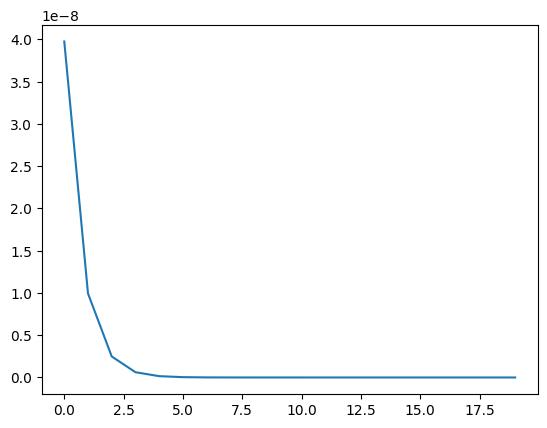

In [49]:
weight = 1/2
diff_record = []
for i in range(20):
    mu0_prev = mu_br[0]
    mu_final = mu_br[-1]
    diff = torch.sum((mu0_prev - mu_final) **2)
    print(diff)
    diff_record.append(diff)
    mu0 = (1 - weight) * mu0_prev + weight * mu_final
    env_instance.update_initial_distribution(mu0)
    L_br = mean_field(env_instance, pi_br)
    mu_br = torch.sum(L_br, axis=2)
plt.plot(diff_record)
print(mu_br)